# Face Verification and Recognition with Inception 
Project created during the Deep Learning Specialization course on www.coursera.org

In [1]:
import warnings
warnings.filterwarnings(action='ignore')
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.core import Lambda, Flatten, Dense
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import sys 
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
from numpy import genfromtxt
import PIL
from PIL import Image 
from collections import defaultdict
from inception_blocks import *

%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = (2,2)
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


## Data preparation

In [2]:
directory = './images'

#### Image preprocessing 

In [3]:
# Preprocess image to match model input size

def preprocess_image(image_path):
   
    # Read the image; flag=1 loads a color image
    img = cv2.imread(image_path, 1) 
  
    # Resize image to match the model input size 
    img = cv2.resize(img, (96, 96))
    
    # OpenCV uses BGR ordering. '...' skips previous dimensions, '::-1' returns all pixels reversed
    img = img[...,::-1] 
    
    # Rearrange image dimensions (channels n_C first) and normalize pixel values 
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
    
    # Convert the image to fit the model input type
    img = np.array([img])

    return img

## Inception model 

#### Building model 

In [4]:
# Built Inception model (implementation used in FaceNet)

def model(input_shape):

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    
    # First Block
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = 1, name = 'bn1')(X)
    X = Activation('relu')(X)
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D((3, 3), strides = 2)(X)
    
    # Second Block
    X = Conv2D(64, (1, 1), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = ZeroPadding2D((1, 1))(X)

    # Third Block
    X = Conv2D(192, (3, 3), strides = (1, 1), name = 'conv3')(X)
    X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn3')(X)
    X = Activation('relu')(X)
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D(pool_size = 3, strides = 2)(X)
    
    # First Inception block
    X = inception_block_1a(X)
    X = inception_block_1b(X)
    X = inception_block_1c(X)
    
    # Second Inception Block
    X = inception_block_2a(X)
    X = inception_block_2b(X)
    
    # Third Inception Block
    X = inception_block_3a(X)
    X = inception_block_3b(X)
    
    # Top layer
    X = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), data_format='channels_first')(X)
    X = Flatten()(X)
    X = Dense(128, name='dense_layer')(X)
    
    # L2 normalization
    X = Lambda(lambda  x: K.l2_normalize(x,axis=1))(X)

    # Create model instance
    model = Model(inputs = X_input, outputs = X, name='FaceRecoModel')
        
    return model

In [5]:
model = model(input_shape=(3, 96, 96))

In [6]:
#model.summary()

#### Defining loss function 
(if we were to train the model from scratch)

In [7]:
# Triplet loss - 
# - encodings of two images of the same person should be similar
# - encodings of two images of different people should be different 

def compute_triplet_loss(y_true, y_pred, alpha=0.2):
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    
    loss = tf.reduce_sum(tf.maximum((pos_dist - neg_dist + alpha), 0)) 
    
    return loss

#### Model compilation 
(if we were to train the model from scratch)

In [8]:
# Compile the model 

model.compile(optimizer = 'adam', 
              loss = compute_triplet_loss, 
              metrics = ['accuracy'])

#### Loading pretrained weights
source: https://github.com/iwantooxxoox/Keras-OpenFace

In [9]:
WEIGHTS = [
  'conv1', 'bn1', 'conv2', 'bn2', 'conv3', 'bn3',
  'inception_3a_1x1_conv', 'inception_3a_1x1_bn',
  'inception_3a_pool_conv', 'inception_3a_pool_bn',
  'inception_3a_5x5_conv1', 'inception_3a_5x5_conv2', 'inception_3a_5x5_bn1', 'inception_3a_5x5_bn2',
  'inception_3a_3x3_conv1', 'inception_3a_3x3_conv2', 'inception_3a_3x3_bn1', 'inception_3a_3x3_bn2',
  'inception_3b_3x3_conv1', 'inception_3b_3x3_conv2', 'inception_3b_3x3_bn1', 'inception_3b_3x3_bn2',
  'inception_3b_5x5_conv1', 'inception_3b_5x5_conv2', 'inception_3b_5x5_bn1', 'inception_3b_5x5_bn2',
  'inception_3b_pool_conv', 'inception_3b_pool_bn',
  'inception_3b_1x1_conv', 'inception_3b_1x1_bn',
  'inception_3c_3x3_conv1', 'inception_3c_3x3_conv2', 'inception_3c_3x3_bn1', 'inception_3c_3x3_bn2',
  'inception_3c_5x5_conv1', 'inception_3c_5x5_conv2', 'inception_3c_5x5_bn1', 'inception_3c_5x5_bn2',
  'inception_4a_3x3_conv1', 'inception_4a_3x3_conv2', 'inception_4a_3x3_bn1', 'inception_4a_3x3_bn2',
  'inception_4a_5x5_conv1', 'inception_4a_5x5_conv2', 'inception_4a_5x5_bn1', 'inception_4a_5x5_bn2',
  'inception_4a_pool_conv', 'inception_4a_pool_bn',
  'inception_4a_1x1_conv', 'inception_4a_1x1_bn',
  'inception_4e_3x3_conv1', 'inception_4e_3x3_conv2', 'inception_4e_3x3_bn1', 'inception_4e_3x3_bn2',
  'inception_4e_5x5_conv1', 'inception_4e_5x5_conv2', 'inception_4e_5x5_bn1', 'inception_4e_5x5_bn2',
  'inception_5a_3x3_conv1', 'inception_5a_3x3_conv2', 'inception_5a_3x3_bn1', 'inception_5a_3x3_bn2',
  'inception_5a_pool_conv', 'inception_5a_pool_bn',
  'inception_5a_1x1_conv', 'inception_5a_1x1_bn',
  'inception_5b_3x3_conv1', 'inception_5b_3x3_conv2', 'inception_5b_3x3_bn1', 'inception_5b_3x3_bn2',
  'inception_5b_pool_conv', 'inception_5b_pool_bn',
  'inception_5b_1x1_conv', 'inception_5b_1x1_bn',
  'dense_layer'
]

In [10]:
conv_shape = {
  'conv1': [64, 3, 7, 7],
  'conv2': [64, 64, 1, 1],
  'conv3': [192, 64, 3, 3],
  'inception_3a_1x1_conv': [64, 192, 1, 1],
  'inception_3a_pool_conv': [32, 192, 1, 1],
  'inception_3a_5x5_conv1': [16, 192, 1, 1],
  'inception_3a_5x5_conv2': [32, 16, 5, 5],
  'inception_3a_3x3_conv1': [96, 192, 1, 1],
  'inception_3a_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_3x3_conv1': [96, 256, 1, 1],
  'inception_3b_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_5x5_conv1': [32, 256, 1, 1],
  'inception_3b_5x5_conv2': [64, 32, 5, 5],
  'inception_3b_pool_conv': [64, 256, 1, 1],
  'inception_3b_1x1_conv': [64, 256, 1, 1],
  'inception_3c_3x3_conv1': [128, 320, 1, 1],
  'inception_3c_3x3_conv2': [256, 128, 3, 3],
  'inception_3c_5x5_conv1': [32, 320, 1, 1],
  'inception_3c_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_3x3_conv1': [96, 640, 1, 1],
  'inception_4a_3x3_conv2': [192, 96, 3, 3],
  'inception_4a_5x5_conv1': [32, 640, 1, 1,],
  'inception_4a_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_pool_conv': [128, 640, 1, 1],
  'inception_4a_1x1_conv': [256, 640, 1, 1],
  'inception_4e_3x3_conv1': [160, 640, 1, 1],
  'inception_4e_3x3_conv2': [256, 160, 3, 3],
  'inception_4e_5x5_conv1': [64, 640, 1, 1],
  'inception_4e_5x5_conv2': [128, 64, 5, 5],
  'inception_5a_3x3_conv1': [96, 1024, 1, 1],
  'inception_5a_3x3_conv2': [384, 96, 3, 3],
  'inception_5a_pool_conv': [96, 1024, 1, 1],
  'inception_5a_1x1_conv': [256, 1024, 1, 1],
  'inception_5b_3x3_conv1': [96, 736, 1, 1],
  'inception_5b_3x3_conv2': [384, 96, 3, 3],
  'inception_5b_pool_conv': [96, 736, 1, 1],
  'inception_5b_1x1_conv': [256, 736, 1, 1],
}

In [11]:
# Helper function: create dictionary of weights

def create_weights_dict(directory):
  
    fileNames = filter(lambda f: not f.startswith('.'), os.listdir(directory))
    paths = {}
    weights_dict = {}

    for n in fileNames:
        paths[n.replace('.csv', '')] = directory + '/' + n

    for name in tqdm(WEIGHTS):
        
        if 'conv' in name:
            conv_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
            conv_w = np.reshape(conv_w, conv_shape[name])
            conv_w = np.transpose(conv_w, (2, 3, 1, 0))
            conv_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
            weights_dict[name] = [conv_w, conv_b]     
            
        elif 'bn' in name:
            bn_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
            bn_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
            bn_m = genfromtxt(paths[name + '_m'], delimiter=',', dtype=None)
            bn_v = genfromtxt(paths[name + '_v'], delimiter=',', dtype=None)
            weights_dict[name] = [bn_w, bn_b, bn_m, bn_v]
            
        elif 'dense' in name:
            dense_w = genfromtxt(directory+'/dense_w.csv', delimiter=',', dtype=None)
            dense_w = np.reshape(dense_w, (128, 736))
            dense_w = np.transpose(dense_w, (1, 0))
            dense_b = genfromtxt(directory+'/dense_b.csv', delimiter=',', dtype=None)
            weights_dict[name] = [dense_w, dense_b]

    return weights_dict

In [12]:
# Load pretrained weights from files

def load_weights(model, directory):
    
    # Load weights from csv files (which was exported from Openface torch model)
    weights = WEIGHTS
    weights_dict = create_weights_dict(directory)
    
    # Set layer weights of the model
    for name in tqdm(weights):
        if model.get_layer(name) != None:
            model.get_layer(name).set_weights(weights_dict[name])

In [13]:
weights_dir = './weights'
load_weights(model, weights_dir)

100%|██████████| 75/75 [00:18<00:00,  4.14it/s]


## Encoding images

#### Encoding by making a prediction

In [14]:
def encode(image_path):
    img = preprocess_image(image_path)
    return model.predict_on_batch(img)

#### Database of identities and corresponding encodings

In [15]:
def create_database(directory):
    
    images = filter(lambda f: not f.startswith('.'), os.listdir(directory))
    database = defaultdict(list)

    for image in images:
        filename, ext = os.path.splitext(image)
        identity = ''.join(i for i in filename if i.isalpha()).capitalize()
        encoding = encode(os.path.join(directory, image))
        database[identity].append(encoding)
    
    return  database

In [16]:
database = create_database(directory)

In [17]:
database.keys()

dict_keys(['Marcelo', 'Jola', 'Ala', 'Michal', 'Marek'])

## Testing 

In [18]:
# Helper function: load image and print true identity that is represents

def load_image(image_path):
    
    image_path = os.path.join(test_dir, image)
    
    # Display the image 
    img = cv2.imread(image_path)
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(RGB_img)
    plt.show()
    
    # Retrieve true identity
    filename = os.path.basename(image_path)
    file, ext = os.path.splitext(filename)
    true_identity = ''.join(i for i in file if i.isalpha()).capitalize()
    print('True identity: {}'.format(true_identity))

#### Face verification

In [19]:
def verify(image_path, identity, database):
    
    # Compute the encoding for the image
    encoding = encode(image_path)
    
    # Compute distance with identity's image
    min_dist = 100
    for each in database[identity]:
        dist = np.linalg.norm(encoding - each)
        min_dist = min(dist, min_dist)
        
    if min_dist < 0.6:
        print("System: Verification succeeded (Distance = %.2f)" % min_dist)
        grant_access = True
    else:
        print("System: Verification failed (Distance = %.2f)" % min_dist)
        grant_access = False
        
    return min_dist, grant_access

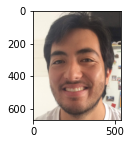

True identity: Marcelo

Test 1


System: What is your identity? 
User: Marcelo


System: Verification succeeded (Distance = 0.57)

Test 2


System: What is your identity? 
User: Michal


System: Verification failed (Distance = 0.93)




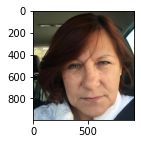

True identity: Jola

Test 1


System: What is your identity? 
User: Jola


System: Verification succeeded (Distance = 0.56)

Test 2


System: What is your identity? 
User: Ala


System: Verification failed (Distance = 0.71)




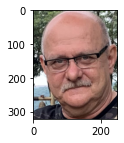

True identity: Marek

Test 1


System: What is your identity? 
User: Marek


System: Verification succeeded (Distance = 0.59)

Test 2


System: What is your identity? 
User: Michal


System: Verification failed (Distance = 0.90)




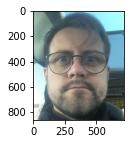

True identity: Michal

Test 1


System: What is your identity? 
User: Michal


System: Verification succeeded (Distance = 0.56)

Test 2


System: What is your identity? 
User: Marek


System: Verification failed (Distance = 0.72)




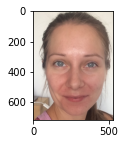

True identity: Ala

Test 1


System: What is your identity? 
User: Ala


System: Verification succeeded (Distance = 0.60)

Test 2


System: What is your identity? 
User: Jola


System: Verification failed (Distance = 0.69)




In [20]:
test_dir = './test'
images = filter(lambda f: not f.startswith('.'), os.listdir(test_dir))

for image in images:
    
    image_path = os.path.join(test_dir, image)
    
    # Load image 
    load_image(image_path)
    
    # Verify if claimed identities are true
    print('\nTest 1')
    claimed_identity = input('System: What is your identity? \nUser:')
    
    while claimed_identity.capitalize() not in database.keys():
        claimed_identity = input('System: {} is not in the database \n\n What is your identity? \nUser:'.format(claimed_identity))
        
    dist, success = verify(image_path, claimed_identity.capitalize(), database)
    
    print('\nTest 2')
    claimed_identity = input('System: What is your identity? \nUser:')
    
    while claimed_identity.capitalize() not in database.keys():
        claimed_identity = input('\nSystem: {} is not in the database. What is your identity? \nUser:'.format(claimed_identity))
        
    verify(image_path, claimed_identity.capitalize(), database)
    
    print('\n')

#### Face recognition

In [21]:
def recognize(image_path, database):
    
    # Encode the input image
    encoding = encode(image_path)
    
    # Initialize min_dist to a large number
    min_dist = 100
    
    for (name, db_enc) in database.items():
        
        # Calculate L2 distance between encoding to recognize and current encoding from the database 
        for each in db_enc:
            
            dist = np.linalg.norm(encoding - each)
            
#             print('%s Distance: %.2f' % (name, dist))
            
            if dist < min_dist:
                min_dist = dist
                identity = name
                
    # Display predicted identity
    print('Prediction: %s \nDistance: %.2f\n' % (identity, min_dist))
    
    return min_dist, identity 

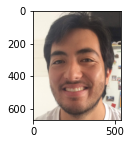

True identity: Marcelo
Prediction: Marcelo 
Distance: 0.57



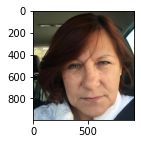

True identity: Jola
Prediction: Jola 
Distance: 0.56



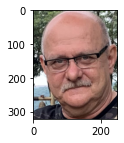

True identity: Marek
Prediction: Marek 
Distance: 0.59



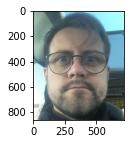

True identity: Michal
Prediction: Michal 
Distance: 0.56



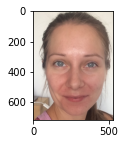

True identity: Ala
Prediction: Ala 
Distance: 0.60



In [22]:
test_dir = './test'
images = filter(lambda f: not f.startswith('.'), os.listdir(test_dir))

for image in images:
    
    img_path = os.path.join(test_dir, image)

    # Load image 
    load_image(image_path)
    
    # Recognize a person 
    min_dist, identity = recognize(img_path, database)